<a href="https://colab.research.google.com/github/lukemckinstry/fastai-projects/blob/master/ships_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image classification on aeriel ship images 

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
#according to error
os.environ['CUDA_LAUNCH_BLOCKING']="1"
import shutil

import cv2

### Get training Data From Drive

In [0]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()
drive_service = build('drive', 'v3')


#### Utilities for Managing Files on Google Drive

In [0]:
def _create_file_request(file_id):
    return drive_service.files().get_media(fileId=file_id)


def _download_response_bytes(request, print_progress=False):
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    
    for status in _progbar(downloader):
        if print_progress:
            print("Downloaded {}/{} bytes".format(status.resumable_progress, status.total_size))
  
    downloaded.seek(0)
    return downloaded.read()

  
def _progbar(downloader):
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        yield status


def get_file_id(name):
    return get_matching_files(name)[0]['id']


def move_from_drive_to_disk(file_names, file_destinations):
    for file_name, dest in zip(file_names, file_destinations):
        file_id = get_file_id(file_name)
        print('Downloading file: "{}"'.format(file_name))
        file_bytes = _download_response_bytes(_create_file_request(file_id), print_progress=True)
        with open(dest, "wb") as f:
            f.write(file_bytes)


def load_pickled_files(file_names):
    for name in file_names:
        yield pickle.load(open(name, "rb"))
        

def get_matching_files(name):
    drive_files_response = _download_response_bytes(drive_service.files().list())
    drive_files_response_dict = json.loads(
        drive_files_response.decode('utf-8')
    )
    drive_files_dict = drive_files_response_dict['files']
  
    matching_records = [
        record
        for record in drive_files_dict
        if record['name'] == name
    ]

    no_records = len(matching_records)
    if no_records == 0:
        raise ValueError('no such file: "{}" on your Google Drive'.format(name))
    elif no_records > 1:
        print('warning: multiple matches for file "{}"'.format(name))
    return matching_records



### create folders and download data

In [5]:
train_file_name = 'ships_super_mini.zip'
label_file_name = 'train_ship_segmentations_v2.csv.zip'
codes_file_name = 'ship_codes.txt'

train_drive_file_id = get_file_id(train_file_name)
label_drive_file_id = get_file_id(label_file_name)
codes_drive_file_id = get_file_id(codes_file_name)


DATA_DIR = Path('/content/data/ships_mini/')
DATA_DIR.mkdir(exist_ok=True, parents=True)
move_from_drive_to_disk([train_file_name], [DATA_DIR/train_file_name])
move_from_drive_to_disk([label_file_name], [DATA_DIR/label_file_name])
move_from_drive_to_disk([codes_file_name], [DATA_DIR/codes_file_name])

#!find '/content/' -type f -name \*.jpg -delete

Downloaded 1467051/1467051 bytes
Downloaded 18849010/18849010 bytes
Downloaded 13/13 bytes


In [0]:
!unzip -o {DATA_DIR}'/ships_super_mini.zip' -d {DATA_DIR}'/Train/'
!unzip -o {DATA_DIR}'/train_ship_segmentations_v2.csv.zip' -d {DATA_DIR}

In [0]:
path_img = Path(DATA_DIR/'Train')

In [0]:
label_df_raw = pd.read_csv(f'{DATA_DIR}/train_ship_segmentations_v2.csv', low_memory=False )
label_df_raw = label_df_raw.replace(np.nan, '', regex=True)

In [0]:
pd.set_option("display.max_colwidth", 10000)

### make dataframe of rle data for masks

In [59]:
ship_files = os.listdir('data/ships_mini/Train')
def in_mini(f):
  return f['ImageId'] in ship_files
masks = label_df_raw[label_df_raw.apply(in_mini, axis=1)]
masks.shape, label_df_raw.shape

((587, 2), (231723, 2))

In [0]:
def label_not_blank(r):
  if r != '':
    return 1
  else:
    return 0

masks['count'] = masks.apply(lambda row: label_not_blank(row['EncodedPixels']), axis=1)


In [0]:
masks = masks.groupby(['ImageId'], as_index=False)['count'].sum()

### Inspect Image, determine how to write masks from rle dataframe


In [41]:
fnames = get_image_files(path_img)
print(fnames[:5])
#img_f = fnames[0]
#img = open_image(img_f)
#print( img.shape[2])
#img.show(figsize=(5,5))
#valid = fnames[-50:]
#len(fnames)
#[i.shape for i in fnames]

[PosixPath('/content/data/ships_mini/Train/00a6fef47.jpg'), PosixPath('/content/data/ships_mini/Train/000913daf.jpg'), PosixPath('/content/data/ships_mini/Train/0097d1602.jpg'), PosixPath('/content/data/ships_mini/Train/007afac42.jpg'), PosixPath('/content/data/ships_mini/Train/0079bd312.jpg')]


### inspect sample img

/content/data/ships_mini/Train/003b48a9e.jpg


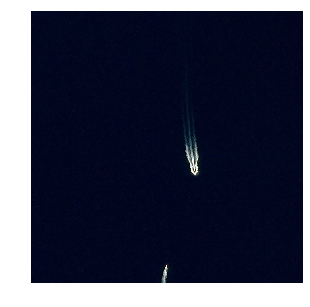

In [34]:
img_f = str(path_img) +'/' +  '003b48a9e.jpg'

print(img_f)

img = open_image(img_f)
img.show(figsize=(5,5))

### Verify Images 

In [0]:
verify_images(sdest, delete=True, max_size=500)
verify_images(nsdest, delete=True, max_size=500)

### DATA Bunch

In [38]:
path_img

PosixPath('/content/data/ships_mini/Train')

In [0]:
data = ImageDataBunch.from_df(path=path_img, df=masks, folder='.', ds_tfms=get_transforms(), 
                              label_col='count', size=224, bs=4 )

In [63]:
data.classes

[0, 1, 2, 3, 4, 5, 6, 7, 9]

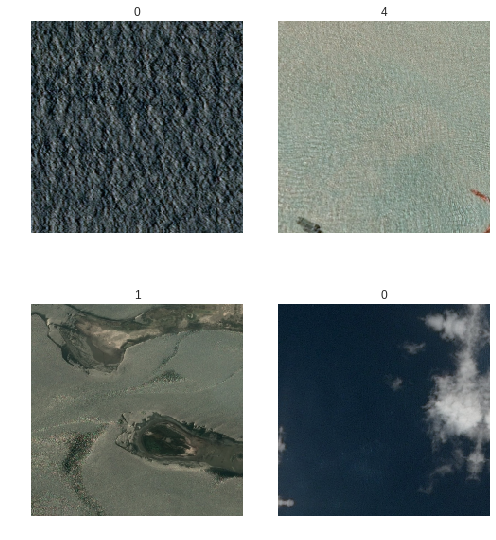

In [64]:
data.show_batch(rows=3, figsize=(7,8))

In [65]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

([0, 1, 2, 3, 4, 5, 6, 7, 9], 9, 400, 100)

## Train Model

In [0]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [67]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
1,1.900760,0.887433,0.240000,00:24
2,0.931344,0.784187,0.250000,00:23
3,0.788799,0.693945,0.210000,00:23
4,0.652537,0.666013,0.230000,00:22


In [0]:
learn.save('stage-1')

In [0]:
!ls {path_img}

models	noship	ship


In [0]:
learn.unfreeze()

In [70]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


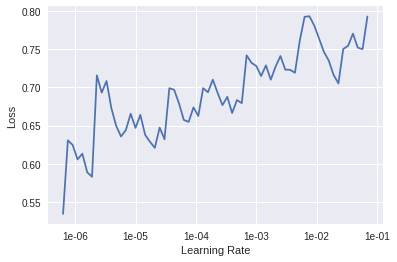

In [71]:
learn.recorder.plot()

In [72]:
learn.fit_one_cycle(4, max_lr=slice(3e-5,3e-3))

epoch,train_loss,valid_loss,error_rate,time
1,0.761423,0.651276,0.180000,00:26
2,0.749144,0.764756,0.200000,00:26
3,0.685249,0.507503,0.150000,00:26
4,0.657008,0.620098,0.160000,00:27


In [0]:
learn.save('stage-2')

## Interpretation

In [0]:
learn.load('stage-2');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [76]:
interp.most_confused(10)

[]

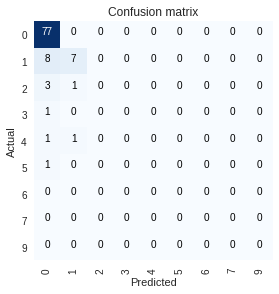

In [77]:
interp.plot_confusion_matrix()

## fin